# Which one is a better plan?

I'm an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

I'm going to carry out a preliminary analysis of Megaline clients: who the clients are which plan they use, and the number of calls they made and text messages they sent in 2018. My job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Description of the plans

Note: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls , each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic , individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

### Surf

Monthly charge: $20

500 monthly minutes, 50 texts, and 15 GB of data

After exceeding the package limits:

1 minute: 3 cents

1 text message: 3 cents

1 GB of data: $10

### Ultimate

Monthly charge: $70

3000 monthly minutes, 1000 text messages, and 30 GB of data

After exceeding the package limits:

1 minute: 1 cent

1 text message: 1 cent

1 GB of data: $7

## Description of the data

Remember! Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls , each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic , individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

The userstable (data on users):

user_id — unique user identifier

first_name — user's name

last_name — user's last name

age — user's age (years)

reg_date — subscription date (dd, mm, yy)

churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)

city ​​— user's city of residence
plan — calling plan name

The callstable (data on calls):

id — unique call identifier

call_date — call date

duration — call duration (in minutes)

user_id — the identifier of the user making the call

The messagestable (data on texts):

id — unique text message identifier

message_date — text message date

user_id — the identifier of the user sending the text

The internettable (data on web sessions):

id — unique session identifier

mb_used — the volume of data spent during the session (in megabytes)

session_date — web session date

user_id — user identifier

The planstable (data on the plans):

plan_name — calling plan name

usd_monthly_fee — monthly charge in US dollars

minutes_included — monthly minute allowance

messages_included — monthly text allowance

mb_per_month_included — data volume allowance (in megabytes)

usd_per_minute — price per minute after exceeding the package limits (eg, if the package includes 100 minutes, the 101st minute will be charged)

usd_per_message — price per text after exceeding the package limits

usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

## Initialization

Let's load all libraries and data files.

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Load data

In [2]:
# Load the data files into different DataFrames
try:
    data_calls=pd.read_csv('/datasets/megaline_calls.csv', parse_dates=['call_date'])
except:
    data_calls=pd.read_csv('C:/Projects/datasets/megaline_calls.csv', parse_dates=['call_date'])

In [3]:
try:
    data_internet=pd.read_csv('/datasets/megaline_internet.csv', parse_dates=['session_date'])
except:
    data_internet=pd.read_csv('C:/Projects/datasets/megaline_internet.csv', parse_dates=['session_date'])

In [4]:
try:
    data_messages=pd.read_csv('/datasets/megaline_messages.csv', parse_dates=['message_date'])
except:
     data_messages=pd.read_csv('C:/Projects/datasets/megaline_messages.csv', parse_dates=['message_date'])

In [5]:
try:
    data_plans=pd.read_csv('/datasets/megaline_plans.csv')
except:
    data_plans=pd.read_csv('C:/Projects/datasets/megaline_plans.csv')

In [6]:
try:
    data_users=pd.read_csv('/datasets/megaline_users.csv', parse_dates=['churn_date', 'reg_date'])
except:
    data_users=pd.read_csv('C:/Projects/datasets/megaline_users.csv', parse_dates=['churn_date', 'reg_date'])

## Prepare the data

## Plans

Let's have a look at plan DataFrame.

In [7]:
# Print the general/summary information about the plans' DataFrame
data_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [8]:
# Print a sample of data for plans
display(data_plans)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The first DataFrame that we'll study will be the one with plans. As we see in the tables above, there are just 2 rows in this DataFrame with no missing values, no duplicates and all data has appropriate type. 

## Users

Let's have a look at users DataFrame.

In [9]:
# Print the general/summary information about the users' DataFrame
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [10]:
# Print a sample of data for users
display(data_users)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaT
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaT
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaT
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaT


   Our next DataFrame сontains data about our users. There are 500 Megaline clients, all of them live in USA, und use one of the two prepaid plans: Surf or Ultimate. We can see missing values in column 'churn_date'. In project description is wriiten that if the value is missing, the calling plan was being used when this database was extracted. So we can replace the missing values in this column with this date. Imagine this date is 2018-12-31.
    
   We checked if there are any duplicates, fortunately there are any. There is a column 'plan_name' in plans DataFrame, in  data for users this column called 'plan'. Let's unify them and name them 'plan_name'.
     After that printed the summary information to chek if it is everything alright now. Yes, it seems nice.

### Fix Data

Let's fix problems in users DataFrame.

In [11]:
data_users['churn_date']=data_users['churn_date'].fillna('2018-12-31')

In [12]:
print(data_users.duplicated().sum())

0


In [13]:
data_users.columns=['user_id','first_name','last_name','age','city','reg_date','plan_name','churn_date']

In [14]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_name   500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Now it is fine

### Enrich Data

For our future analysis we need to take columns about city where client lives, his tariff plan and id. 

In [15]:
users_grouped= data_users[['plan_name','user_id', 'city']]

In [16]:
display(users_grouped)

,plan_name,user_id,city
0,ultimate,1000,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA"
2,surf,1002,"Las Vegas-Henderson-Paradise, NV MSA"
3,surf,1003,"Tulsa, OK MSA"
4,surf,1004,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...
495,surf,1495,"New York-Newark-Jersey City, NY-NJ-PA MSA"
496,surf,1496,"New Orleans-Metairie, LA MSA"
497,ultimate,1497,"Los Angeles-Long Beach-Anaheim, CA MSA"
498,surf,1498,"New York-Newark-Jersey City, NY-NJ-PA MSA"


## Calls

   DataFrame number 3 contents info about calls. There are 137735 rows here and no missing values. We just have problems with data types. Column 'id' should be int64. Duplicates check showed that there are any. 

In [17]:
# Print the general/summary information about the calls' DataFrame
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [18]:
# Print a sample of data for calls
display(data_calls)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


In [19]:
print(data_calls.duplicated().sum())

0


### Fix data

Let's fix problems in calls DataFrame.

In [20]:
data_calls['id']=data_calls['id'].astype(int)

In [21]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  int32         
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 3.7 MB


Test after all our manipulations shows that we did everything right.

### Enrich data

For calculation of the monthly revenue from each user we need column with information about month when call was made. Also we need to round up calls duration for our future analysis. 

In [22]:
data_calls['month'] = data_calls['call_date'].dt.month

In [23]:
data_calls['duration'] = np.ceil(data_calls['duration']).astype(int)

In [24]:
display(data_calls)

,id,user_id,call_date,duration,month
0,100093,1000,2018-12-27,9,12
1,1000145,1000,2018-12-27,14,12
2,1000247,1000,2018-12-27,15,12
3,1000309,1000,2018-12-28,6,12
4,1000380,1000,2018-12-30,5,12
...,...,...,...,...,...
137730,1499199,1499,2018-11-21,9,11
137731,1499200,1499,2018-10-20,11,10
137732,1499201,1499,2018-09-21,9,9
137733,1499202,1499,2018-10-10,1,10


Done.

## Messages

DataFrame with data about messages contains 76051 rows and 3 columns. We can see any missing values or duplicates. We just have to change data type: column 'id' to int. What we successfully did.

In [25]:
# Print the general/summary information about the messages' DataFrame
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [26]:
# Print a sample of data for messages
display(data_messages)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


In [27]:
print(data_messages.duplicated().sum())

0


### Fix data

In [28]:
data_messages['id']=data_messages['id'].astype(int)

In [29]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int32         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 1.5 MB


### Enrich data

We need information about month when messages were sent, so let's make a column with this information.

In [30]:
data_messages['month'] = data_messages['message_date'].dt.month

In [31]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  int32         
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 2.0 MB


## Internet

The last DataFrame has info about internet. There are 104825 entries here and 4 columns, any missing values and any duplicates. We had to change types in column 'id' and we did it.

In [32]:
# Print the general/summary information about the internet DataFrame
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [33]:
display(data_internet)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


In [34]:
print(data_internet.duplicated().sum())

0


### Fix data

In [35]:
data_internet['id']=data_internet['id'].astype(int)

In [36]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  int32         
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 2.8 MB


### Enrich data

We need to make additional factor 'month' because I believe it might be useful.

In [37]:
data_internet['month'] = data_internet['session_date'].dt.month

## Study plan conditions

In [38]:
# Print out the plan conditions and make sure they are clear for you
display(data_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

Our next step will be an aggregation data per user per period in order to have just one record per user per period. It should ease the further analysis a lot

In [39]:
# Calculate the number of calls made by each user per month. Save the result.
number_calls= data_calls.groupby(['user_id','month'])['id'].count().reset_index()

In [40]:
# Calculate the amount of minutes spent by each user per month. Save the result.
duration_calls= data_calls.groupby(['user_id','month'])['duration'].sum().reset_index()

In [41]:
display(duration_calls)

,user_id,month,duration
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2253,1498,12,339
2254,1499,9,346
2255,1499,10,385
2256,1499,11,308


In [42]:
# Calculate the number of messages sent by each user per month. Save the result.
number_message= data_messages.groupby(['user_id','month'])['id'].count().reset_index()

In [43]:
display(number_message)

,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [44]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
duration_internet= data_internet.groupby(['user_id','month'])['mb_used'].sum().reset_index()

We need to roundup values in column 'mb_used'. 

In [45]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype(int)

In [46]:
display(duration_internet)

,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
...,...,...,...
2272,1498,12,23137.69
2273,1499,9,12984.76
2274,1499,10,19492.43
2275,1499,11,16813.83


Now we put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month

In [47]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
total1=pd.merge(left = duration_calls, 
                right = number_message, how='outer',on=['user_id', 'month']).fillna(0)
total2=pd.merge(left = total1 , 
                right = duration_internet, how='outer',on=['user_id', 'month']).fillna(0)
total3= pd.merge(left = total2 , 
                right = number_calls, how='outer',on=['user_id', 'month']).fillna(0)

In [48]:
display(total3)

,user_id,month,duration,id_x,mb_used,id_y
0,1000,12,124.0,11.0,1901.47,16.0
1,1001,8,182.0,30.0,6919.15,27.0
2,1001,9,315.0,44.0,13314.82,49.0
3,1001,10,393.0,53.0,22330.49,65.0
4,1001,11,426.0,36.0,18504.30,64.0
...,...,...,...,...,...,...
2288,1349,12,0.0,61.0,13039.91,0.0
2289,1361,5,0.0,2.0,1519.69,0.0
2290,1482,10,0.0,2.0,0.00,0.0
2291,1108,12,0.0,0.0,233.17,0.0


Let's give more understandable names to our columns.

In [49]:
total3.columns=['user_id', 'month', 'calls_duration', 'number_messages', 'mb_used','number_calls']

In [50]:
display(total3)

,user_id,month,calls_duration,number_messages,mb_used,number_calls
0,1000,12,124.0,11.0,1901.47,16.0
1,1001,8,182.0,30.0,6919.15,27.0
2,1001,9,315.0,44.0,13314.82,49.0
3,1001,10,393.0,53.0,22330.49,65.0
4,1001,11,426.0,36.0,18504.30,64.0
...,...,...,...,...,...,...
2288,1349,12,0.0,61.0,13039.91,0.0
2289,1361,5,0.0,2.0,1519.69,0.0
2290,1482,10,0.0,2.0,0.00,0.0
2291,1108,12,0.0,0.0,233.17,0.0


Let's make our data look more beatifull and change datatype of all values from float to integer.

In [51]:
total3['calls_duration']=total3['calls_duration'].astype(int)
total3['number_messages']=total3['number_messages'].astype(int)
total3['mb_used']=total3['mb_used'].astype(int)
total3['number_calls']=total3['number_calls'].astype(int)

In [52]:
display(total3)

,user_id,month,calls_duration,number_messages,mb_used,number_calls
0,1000,12,124,11,1901,16
1,1001,8,182,30,6919,27
2,1001,9,315,44,13314,49
3,1001,10,393,53,22330,65
4,1001,11,426,36,18504,64
...,...,...,...,...,...,...
2288,1349,12,0,61,13039,0
2289,1361,5,0,2,1519,0
2290,1482,10,0,2,0,0
2291,1108,12,0,0,233,0


Now it is the time to join plan DataFrame and users_grouped inaormation.

In [53]:
# Add the plan information
total_plan= pd.merge(left = data_plans, 
                right = users_grouped, how='outer',on=['plan_name']).fillna(0)


In [54]:
display(total_plan)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,user_id,city
0,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA"
1,50,15360,500,20,10,0.03,0.03,surf,1002,"Las Vegas-Henderson-Paradise, NV MSA"
2,50,15360,500,20,10,0.03,0.03,surf,1003,"Tulsa, OK MSA"
3,50,15360,500,20,10,0.03,0.03,surf,1004,"Seattle-Tacoma-Bellevue, WA MSA"
4,50,15360,500,20,10,0.03,0.03,surf,1005,"Dallas-Fort Worth-Arlington, TX MSA"
...,...,...,...,...,...,...,...,...,...,...
495,1000,30720,3000,70,7,0.01,0.01,ultimate,1482,"New York-Newark-Jersey City, NY-NJ-PA MSA"
496,1000,30720,3000,70,7,0.01,0.01,ultimate,1487,"Cape Coral-Fort Myers, FL MSA"
497,1000,30720,3000,70,7,0.01,0.01,ultimate,1490,"Sacramento–Roseville–Folsom, CA MSA"
498,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA"


And finally join everything together.

In [55]:
final_table= pd.merge(left = total_plan, 
                right = total3, how='outer',on=['user_id']).fillna(0)


In [56]:
display(final_table)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,user_id,city,month,calls_duration,number_messages,mb_used,number_calls
0,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",8.0,182.0,30.0,6919.0,27.0
1,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",9.0,315.0,44.0,13314.0,49.0
2,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",10.0,393.0,53.0,22330.0,65.0
3,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",11.0,426.0,36.0,18504.0,64.0
4,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",12.0,412.0,44.0,19369.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",9.0,529.0,0.0,14991.0,66.0
2299,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",10.0,450.0,0.0,16329.0,66.0
2300,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",11.0,500.0,0.0,15630.0,73.0
2301,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",12.0,473.0,0.0,15289.0,65.0


In [57]:
final_table['month']=final_table['month'].astype(int)

We have 10 values '0' in column 'month', let's have a look information about these rows. There are 0 in all columns here, there is no usefull information about these clients, probably these are people who did not use telecom service throughout the year, so we decide to drop them.

In [58]:
display(final_table[final_table['month']==0])

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,user_id,city,month,calls_duration,number_messages,mb_used,number_calls
422,50,15360,500,20,10,0.03,0.03,surf,1129,"Baton Rouge, LA MSA",0,0.0,0.0,0.0,0.0
476,50,15360,500,20,10,0.03,0.03,surf,1143,"Cincinnati, OH-KY-IN MSA",0,0.0,0.0,0.0,0.0
989,50,15360,500,20,10,0.03,0.03,surf,1307,"Boston-Cambridge-Newton, MA-NH MSA",0,0.0,0.0,0.0,0.0
1026,50,15360,500,20,10,0.03,0.03,surf,1319,"Colorado Springs, CO MSA",0,0.0,0.0,0.0,0.0
1264,50,15360,500,20,10,0.03,0.03,surf,1378,"Denver-Aurora-Lakewood, CO MSA",0,0.0,0.0,0.0,0.0
1502,50,15360,500,20,10,0.03,0.03,surf,1473,"Louisville/Jefferson County, KY-IN MSA",0,0.0,0.0,0.0,0.0
1593,1000,30720,3000,70,7,0.01,0.01,ultimate,1025,"Atlanta-Sandy Springs-Roswell, GA MSA",0,0.0,0.0,0.0,0.0
1980,1000,30720,3000,70,7,0.01,0.01,ultimate,1269,"Dallas-Fort Worth-Arlington, TX MSA",0,0.0,0.0,0.0,0.0
1989,1000,30720,3000,70,7,0.01,0.01,ultimate,1275,"New York-Newark-Jersey City, NY-NJ-PA MSA",0,0.0,0.0,0.0,0.0
2249,1000,30720,3000,70,7,0.01,0.01,ultimate,1463,"Atlanta-Sandy Springs-Roswell, GA MSA",0,0.0,0.0,0.0,0.0


In [59]:
final_table=final_table[final_table['month']!=0]

We calculated the monthly revenue from each user and add special column with this information in final table.

In [60]:
# Calculate the monthly revenue for each user
def revenue(row):
    tarriff = row['plan_name']
    month_pay = final_table[final_table['plan_name']==tarriff]['usd_monthly_pay'].iloc[0]
   
    minutes = row['calls_duration']
    minutes_inc = final_table[final_table['plan_name']==tarriff]['minutes_included'].iloc[0]
    minutes_fee = final_table[final_table['plan_name']==tarriff]['usd_per_minute'].iloc[0]
        
    minutes_add = minutes - minutes_inc
    if minutes_add <=0:
        minutes_cost = 0
    else:
        minutes_cost = minutes_add * minutes_fee
      
    messages = row['number_messages']
    messages_inc = final_table[final_table['plan_name']==tarriff]['messages_included'].iloc[0]
    messages_fee = final_table[final_table['plan_name']==tarriff]['usd_per_message'].iloc[0]
        
    messages_add = messages - messages_inc
    if messages_add <=0:
        messages_cost = 0
    else:
        messages_cost = messages_add * messages_fee
    
    internet = row['mb_used']
    internet_inc = final_table[final_table['plan_name']==tarriff]['mb_per_month_included'].iloc[0]
    internet_fee = final_table[final_table['plan_name']==tarriff]['usd_per_gb'].iloc[0]
   
    
    internet_add = internet - internet_inc
    if internet_add <=0:
        internet_cost = 0
    else:
        internet_cost = np.ceil(internet_add/1024) * internet_fee
        
    total_payment=month_pay+minutes_cost+messages_cost+internet_cost
    return total_payment

final_table['revenue_total']=final_table.apply(revenue, axis=1)
 
    

In [61]:
display(final_table)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,user_id,city,month,calls_duration,number_messages,mb_used,number_calls,revenue_total
0,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",8,182.0,30.0,6919.0,27.0,20.00
1,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",9,315.0,44.0,13314.0,49.0,20.00
2,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",10,393.0,53.0,22330.0,65.0,90.09
3,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",11,426.0,36.0,18504.0,64.0,60.00
4,50,15360,500,20,10,0.03,0.03,surf,1001,"Seattle-Tacoma-Bellevue, WA MSA",12,412.0,44.0,19369.0,56.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",9,529.0,0.0,14991.0,66.0,70.00
2299,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",10,450.0,0.0,16329.0,66.0,70.00
2300,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",11,500.0,0.0,15630.0,73.0,70.00
2301,1000,30720,3000,70,7,0.01,0.01,ultimate,1493,"Boston-Cambridge-Newton, MA-NH MSA",12,473.0,0.0,15289.0,65.0,70.00


## Study user behaviour

   Now we are going to calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. We also will draw useful plots to help the understanding. 
   
   First of all we'll study data about calls. To compare average duration of calls per each plan per each distinct month we choose median because duration of calls varies a lot. 

### Calls

In [62]:
#Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it
compare_duration=final_table.pivot_table(index='month', columns= 'plan_name', values='calls_duration', aggfunc='median')

In [63]:
display(compare_duration)

plan_name,surf,ultimate
month,,
1,203.0,234.0
2,254.0,428.0
3,334.0,251.0
4,339.5,301.0
5,415.0,407.0
6,423.0,399.0
7,454.0,430.0
8,392.0,406.0
9,426.0,434.0


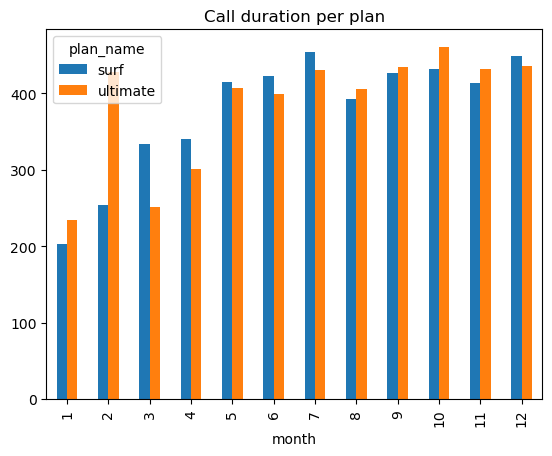

In [136]:
compare_duration.plot(kind='bar');
plt.title('Average call duration per plan')
plt.show()

The plot of average values shows us that there is a little difference between average calls duration of two plans. Medians of call duration are higher among Ultimate's users in winter and autumn monthes (except December), while medians of call duration among Surf's users are higher in spring and summer(except August).

Let's compare the total duration of each plan require each month.

In [65]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
compare_minutes=final_table.pivot_table(index='month', columns= 'plan_name', values='calls_duration', aggfunc='sum')

In [66]:
display(compare_minutes)

plan_name,surf,ultimate
month,,
1,406.0,774.0
2,2673.0,2822.0
3,7590.0,3651.0
4,17577.0,7074.0
5,30768.0,11781.0
6,41836.0,17435.0
7,54448.0,25197.0
8,66438.0,29922.0
9,80360.0,37626.0


In [67]:
surf = final_table[final_table['plan_name']=='surf']
ultimate = final_table[final_table['plan_name']=='ultimate']
ultimate.info()
surf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 1579 to 2302
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      720 non-null    int64  
 1   mb_per_month_included  720 non-null    int64  
 2   minutes_included       720 non-null    int64  
 3   usd_monthly_pay        720 non-null    int64  
 4   usd_per_gb             720 non-null    int64  
 5   usd_per_message        720 non-null    float64
 6   usd_per_minute         720 non-null    float64
 7   plan_name              720 non-null    object 
 8   user_id                720 non-null    int64  
 9   city                   720 non-null    object 
 10  month                  720 non-null    int32  
 11  calls_duration         720 non-null    float64
 12  number_messages        720 non-null    float64
 13  mb_used                720 non-null    float64
 14  number_calls           720 non-null    float64
 15  re

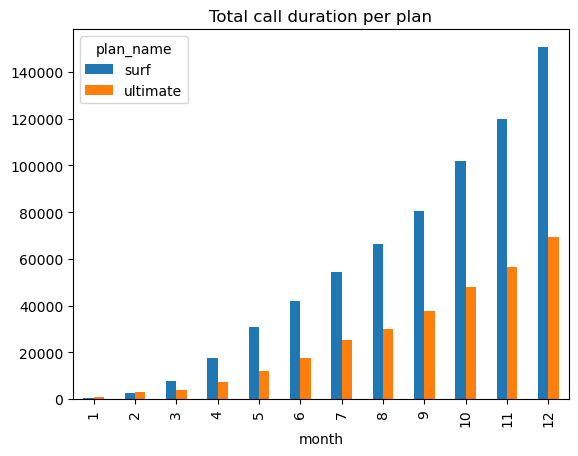

In [137]:
compare_minutes.plot(kind='bar');
plt.title('Total call duration per plan')
plt.show()

Total calls duration is higher among Surf's users, but we should keep in mind that Surf users are twice as many as Ultimate users.

Let's calculate the mean and the variance of the monthly call duration.

plan_name,surf,ultimate
month,,
1,203.000000,193.500000
2,297.000000,403.142857
3,330.000000,304.250000
4,351.540000,336.857143
5,399.584416,406.241379
6,431.298969,370.957447
7,449.983471,427.067797
8,410.111111,421.436620
9,414.226804,437.511628


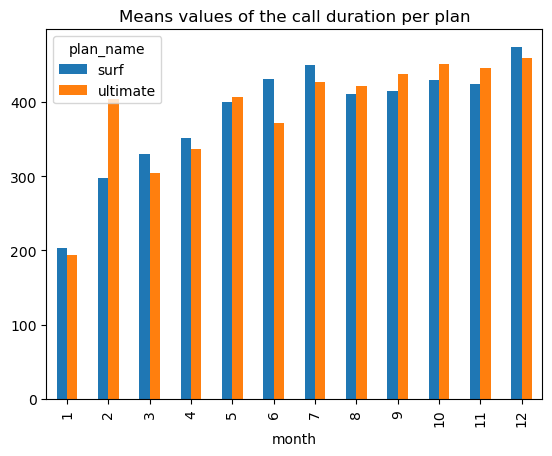

In [138]:
# Calculate the mean and the variance of the monthly call duration
duration_mean=final_table.pivot_table(index='month', columns= 'plan_name', values='calls_duration', aggfunc='mean')
display(duration_mean)
duration_mean.plot(kind='bar');
plt.title('Means values of the call duration per plan')
plt.show()

According to the plot above there is no significant difference between mean values of call duration Ultimate's users and Surf's users. 

In [70]:
surf = final_table[final_table['plan_name']=='surf']

surf_var=surf.groupby('month')['calls_duration'].apply(lambda x: np.var(x))
display(surf_var)

month
1      7921.000000
2     46423.555556
3     34252.434783
4     49849.408400
5     58978.190926
6     45122.601339
7     60500.925347
8     54009.185185
9     46355.773302
10    52058.078976
11    51424.664636
12    63429.426091
Name: calls_duration, dtype: float64

In [71]:
ultimate = final_table[final_table['plan_name']=='ultimate']
ultimate_var=ultimate.groupby('month')['calls_duration'].apply(lambda x: np.var(x))
print(ultimate_var)

month
1     12429.250000
2     65905.265306
3     56819.520833
4     33227.551020
5     42329.286564
6     41599.232232
7     71333.486929
8     52889.936124
9     56406.854516
10    53750.005696
11    60116.110856
12    62089.851059
Name: calls_duration, dtype: float64


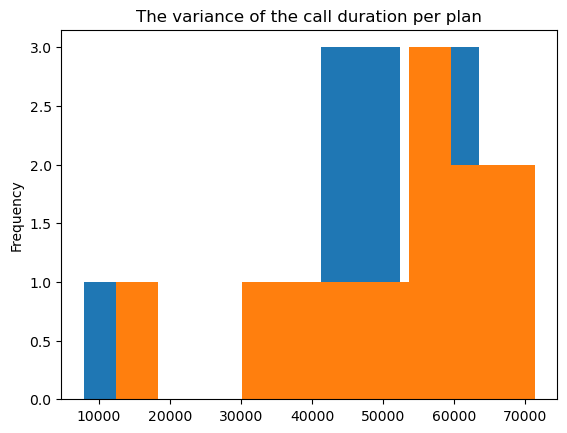

In [139]:
surf_var.plot(kind='hist');
ultimate_var.plot(kind='hist');
plt.title('The variance of the call duration per plan')
plt.show()

   According to our data the duration is low in the beginning of the year and is growing by the end of the year. Variance is also slightly growing by the end of the year.

Let's plot a boxplot to visualize the distribution of the monthly call duration

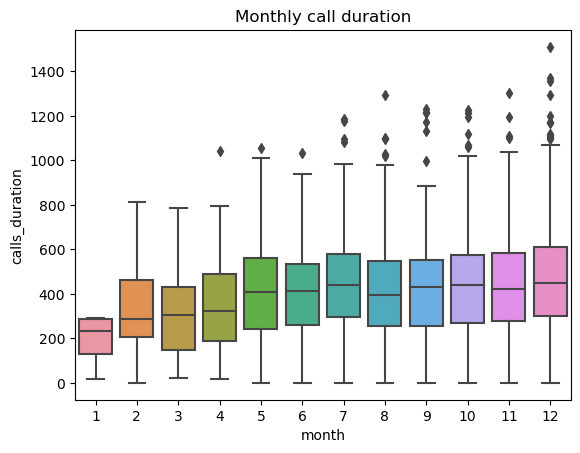

In [140]:
# Plot a boxplot to visualize the distribution of the monthly call duration
sns.boxplot(data=final_table, y="calls_duration", x="month")
plt.title('Monthly call duration')
plt.show()

   Summing up we can say that average values of calls duration Ultimate's users and Surf's are close to each other. The duration and variance are becoming higher by the end of the year. 

Let's study calls duration deeper.

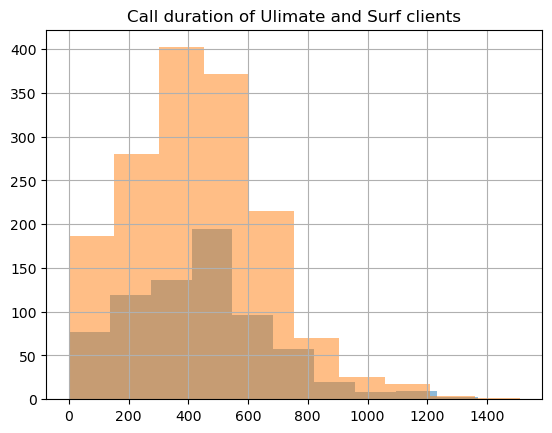

In [141]:
ultimate['calls_duration'].hist(alpha = 0.5);
surf['calls_duration'].hist(alpha = 0.5);
plt.title('Call duration of Ulimate and Surf clients')
plt.show()

In [131]:
ultimate_st_dev=np.sqrt(ultimate_var)
st_dev_surf=np.sqrt(surf_var)

In [132]:
display(ultimate_st_dev)
display(st_dev_surf)

month
1     111.486546
2     256.720208
3     238.368456
4     182.284259
5     205.740824
6     203.958898
7     267.083296
8     229.978121
9     237.501273
10    231.840475
11    245.185870
12    249.178352
Name: calls_duration, dtype: float64

month
1      89.000000
2     215.461262
3     185.074133
4     223.269811
5     242.854259
6     212.420812
7     245.969359
8     232.398763
9     215.303909
10    228.162396
11    226.770070
12    251.851992
Name: calls_duration, dtype: float64

The distribution of calls duration among Surf clients has right skrew, among Ultimate clients it is left skrewed. Standard deviation of calls duration is a bigger in the Ultimate tariff plan. So the spread between duration values in the Ultimate tariff plan is bigger.

### Messages

   What can we say about messages? 

In [81]:
# Compare the number of messages users of each plan tend to send each month
compare_messages=final_table.pivot_table(index='month', columns= 'plan_name', values='number_messages', aggfunc='sum')

In [82]:
display(compare_messages)

plan_name,surf,ultimate
month,,
1,21.0,62.0
2,108.0,151.0
3,351.0,243.0
4,870.0,463.0
5,1849.0,931.0
6,2454.0,1379.0
7,3271.0,1937.0
8,4662.0,2732.0
9,5968.0,3259.0


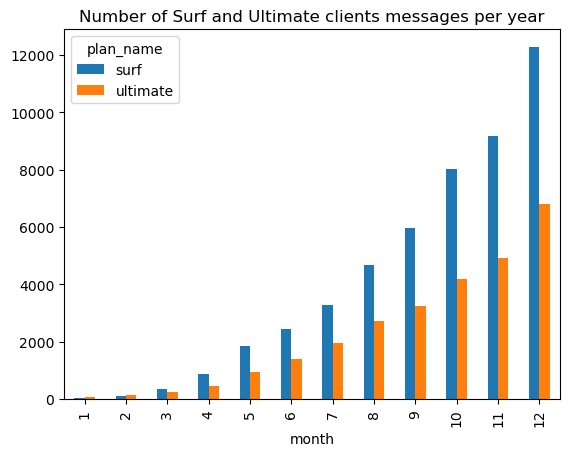

In [142]:
compare_messages.plot(kind='bar')
plt.title('Number of Surf and Ultimate clients messages per year')
plt.show()

In [84]:
# Calculate the mean and the variance of the monthly call duration
messages_mean=final_table.pivot_table(index='month', columns= 'plan_name', values='number_messages', aggfunc='mean')
display(messages_mean)

plan_name,surf,ultimate
month,,
1,10.500000,15.500000
2,12.000000,21.571429
3,15.260870,20.250000
4,17.400000,22.047619
5,24.012987,32.103448
6,25.298969,29.340426
7,27.033058,32.830508
8,28.777778,38.478873
9,30.762887,37.895349


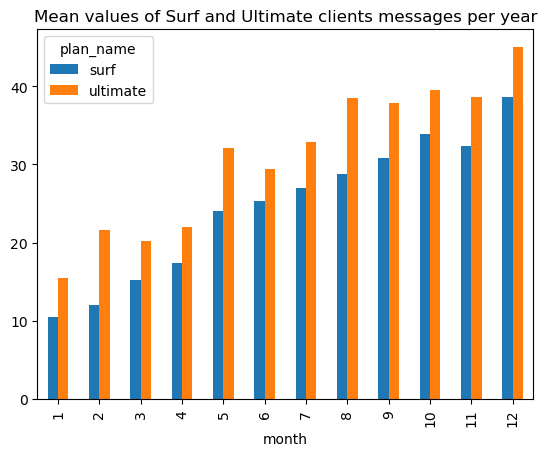

In [135]:
messages_mean.plot(kind='bar')
plt.title('Number of messages: mean values per year')
plt.show()

In [86]:
ultimate_var_mes=ultimate.groupby('month')['number_messages'].apply(lambda x: np.var(x))
surf_var_mes=surf.groupby('month')['number_messages'].apply(lambda x: np.var(x))

In [87]:
display(ultimate_var_mes)
display(surf_var_mes)

month
1      235.250000
2      409.959184
3      599.854167
4      518.235828
5     1252.575505
6      839.373472
7      944.208561
8     1179.517159
9     1038.698350
10    1209.586419
11    1222.963110
12    1539.158897
Name: number_messages, dtype: float64

month
1      110.250000
2      343.111111
3      331.497164
4      491.560000
5      836.194637
6      905.487937
7      916.279899
8     1023.160494
9      998.655117
10    1270.083997
11    1061.579568
12    1453.573207
Name: number_messages, dtype: float64

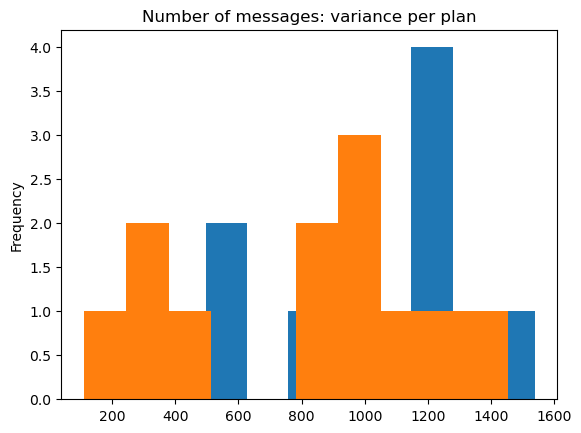

In [143]:
ultimate_var_mes.plot(kind='hist')
surf_var_mes.plot(kind='hist')
plt.title('Number of messages: variance per plan')
plt.show()

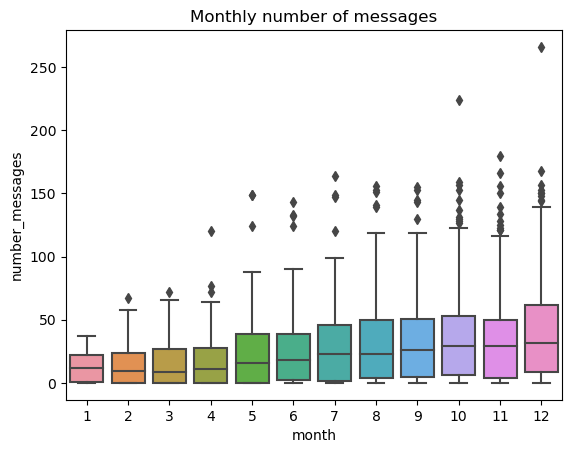

In [144]:
# Plot a boxplot to visualize the distribution of the monthly number of messages
sns.boxplot(data=final_table, y="number_messages", x="month")
plt.title('Monthly number of messages')
plt.show()

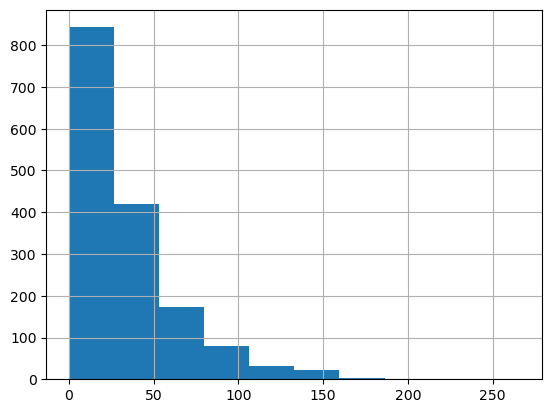

In [90]:
surf['number_messages'].hist()
plt.title('Number of messages among Surf clients')
plt.show()

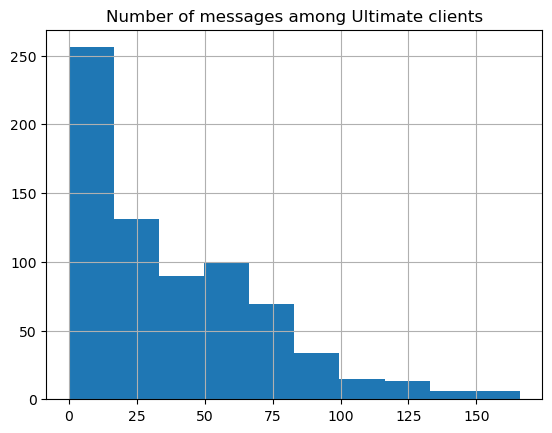

In [145]:
ultimate['number_messages'].hist()
plt.title('Number of messages among Ultimate clients')
plt.show()

In [92]:
surf_st_dev_mess=np.sqrt(surf_var_mes)

In [93]:
ultimate_st_dev_mess=np.sqrt(ultimate_var_mes)

In [94]:
display(surf_st_dev_mess)

month
1     10.500000
2     18.523259
3     18.207064
4     22.171152
5     28.917030
6     30.091327
7     30.270116
8     31.986880
9     31.601505
10    35.638238
11    32.581890
12    38.125755
Name: number_messages, dtype: float64

In [95]:
display(ultimate_st_dev_mess)

month
1     15.337862
2     20.247449
3     24.491920
4     22.764794
5     35.391743
6     28.971943
7     30.727977
8     34.344099
9     32.228843
10    34.779109
11    34.970889
12    39.232116
Name: number_messages, dtype: float64

Surf users write more messages than Ultimate users. But we remember that the total amount of Surf plan users is higher. It's interesting to study the average values. As we can see they are higher among Ultimate users, wich means that the average person who use Ultimate plan write more messages per month than person who use Surf. The number of messages and the variance are growing by the end of the year.

### Internet

   Our next step is to study data on the Internet. As we can see from the tables below, the situation with the Internet looks similar to calls. Surf users consume more mb of Internet but the average values of this parameter are close between Surf and Ultimate users. Clients of the mobile plans use the same amount of the Internet during the year.

In [96]:
# Compare the user's internet consuming of each plan in each month
compare_internet=final_table.pivot_table(index='month', columns= 'plan_name', values='mb_used', aggfunc='median')

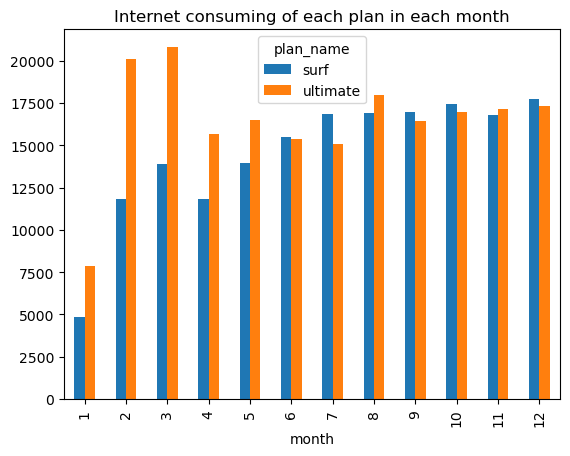

In [146]:
compare_internet.plot(kind='bar')
plt.title('The average Internet consuming of each plan in each month')
plt.show()

In [98]:
internet_gb=final_table.pivot_table(index='month', columns= 'plan_name', values='mb_used', aggfunc='sum')
display(internet_gb)

plan_name,surf,ultimate
month,,
1,9748.0,27670.0
2,109606.0,119897.0
3,306934.0,219853.0
4,599185.0,338545.0
5,1073062.0,482095.0
6,1484201.0,720860.0
7,2030755.0,964313.0
8,2720766.0,1264810.0
9,3218639.0,1459365.0


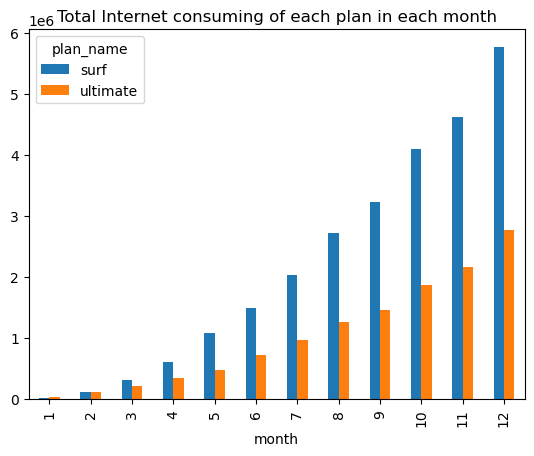

In [147]:
internet_gb.plot(kind='bar')
plt.title('Total Internet consuming of each plan in each month')
plt.show()

In [100]:
internet_mean=final_table.pivot_table(index='month', columns= 'plan_name', values='mb_used', aggfunc='mean')
display(internet_mean)

plan_name,surf,ultimate
month,,
1,4874.000000,6917.500000
2,12178.444444,17128.142857
3,13344.956522,18321.083333
4,11983.700000,16121.190476
5,13935.870130,16623.965517
6,15301.041237,15337.446809
7,16783.099174,16344.288136
8,16794.851852,17814.225352
9,16590.922680,16969.360465


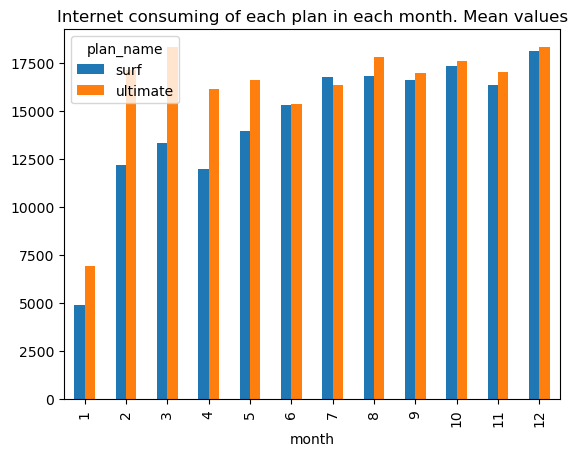

In [148]:
internet_mean.plot(kind='bar')
plt.title('Internet consuming of each plan in each month. Mean values')
plt.show()

In [102]:
ultimate_var_int=ultimate.groupby('month')['mb_used'].apply(lambda x: np.var(x))
surf_var_int=surf.groupby('month')['mb_used'].apply(lambda x: np.var(x))

In [103]:
print(ultimate_var_int)
display(surf_var_int)

month
1     1.229526e+07
2     3.226895e+07
3     1.286442e+08
4     8.421857e+07
5     5.483017e+07
6     7.048187e+07
7     6.725852e+07
8     5.959585e+07
9     4.876554e+07
10    5.645776e+07
11    5.713586e+07
12    6.147095e+07
Name: mb_used, dtype: float64


month
1     9.120400e+06
2     3.882145e+07
3     6.527774e+07
4     5.786312e+07
5     6.067807e+07
6     4.862615e+07
7     6.415221e+07
8     7.417579e+07
9     5.105165e+07
10    6.226318e+07
11    5.697310e+07
12    7.192064e+07
Name: mb_used, dtype: float64

<AxesSubplot:ylabel='Frequency'>

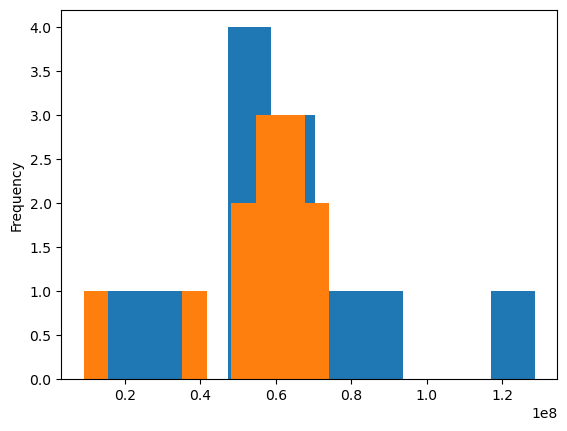

In [104]:
ultimate_var_int.plot(kind='hist')
surf_var_int.plot(kind='hist')
plt.title('Internet consuming of each plan. Variance')
plt.show()

<AxesSubplot:xlabel='month', ylabel='mb_used'>

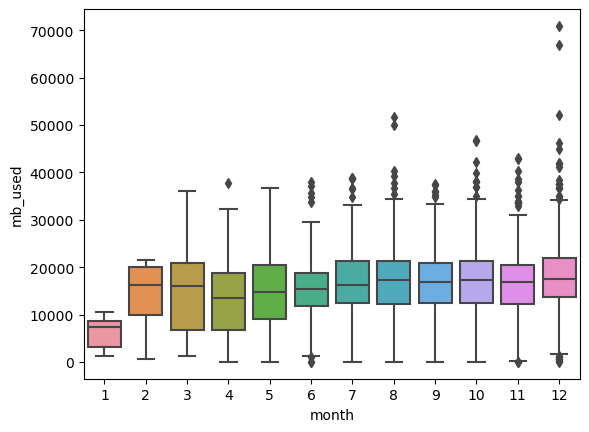

In [105]:
# Plot a boxplot to visualize the distribution of the monthly internet consuming
sns.boxplot(data=final_table, y="mb_used", x="month")
plt.title('Internet consuming in each month')
plt.show()

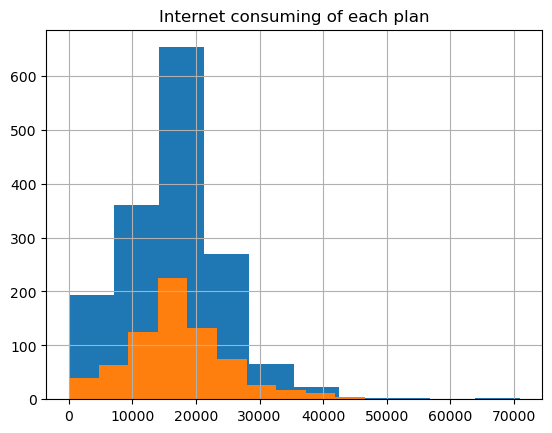

In [150]:
surf['mb_used'].hist()
ultimate['mb_used'].hist();
plt.title('Internet consuming of each plan')
plt.show()

In [108]:
surf_st_dev_int=np.sqrt(surf_var_int)

In [109]:
display(surf_st_dev_int)

month
1     3020.000000
2     6230.686428
3     8079.464088
4     7606.781028
5     7789.613008
6     6973.245093
7     8009.507248
8     8612.536605
9     7145.043618
10    7890.701848
11    7548.052453
12    8480.603465
Name: mb_used, dtype: float64

In [110]:
ultimate_st_dev_int=np.sqrt(ultimate_var_int)

In [111]:
display(ultimate_st_dev_int)

month
1      3506.459504
2      5680.576315
3     11342.140461
4      9177.067779
5      7404.739389
6      8395.348382
7      8201.129391
8      7719.834621
9      6983.232905
10     7513.837799
11     7558.826759
12     7840.341384
Name: mb_used, dtype: float64

The distribution of using the Internet among Surf clients has a little left skew, among Ultimate users it's a little right skew, but both distributions are close to normal. The distribution of Surf clients's Internet consumption has bigger standart deviation. Surf clients use Internet more.

## Revenue

   The most important issue of our analysis is to study the revenue of each plan. Let's start.

In [112]:
# Compare the revenue of each plan in each month
compare_revenue=final_table.pivot_table(index='month', columns= 'plan_name', values='revenue_total', aggfunc='median')
display(compare_revenue)


plan_name,surf,ultimate
month,,
1,20.000,70.0
2,29.570,70.0
3,20.000,70.0
4,20.000,70.0
5,21.740,70.0
6,30.150,70.0
7,40.330,70.0
8,41.980,70.0
9,40.045,70.0


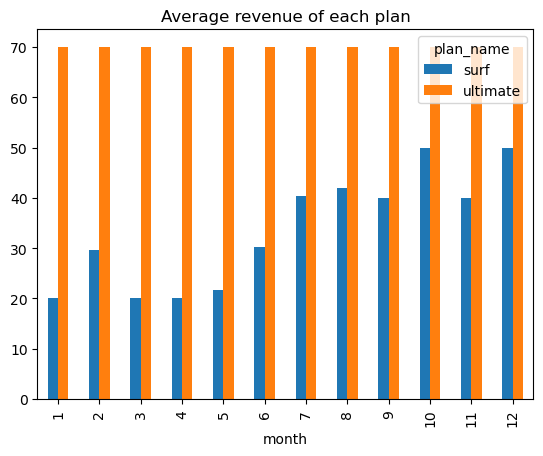

In [154]:
compare_revenue.plot(kind='bar')
plt.title('Average revenue of each plan')
plt.show()

plan_name,surf,ultimate
month,,
1,40.00,280.0
2,309.57,490.0
3,1056.65,896.0
4,2035.53,1533.0
5,3667.37,2051.0
6,4779.80,3367.0
7,7583.56,4242.0
8,10356.85,5173.0
9,11294.67,6195.0


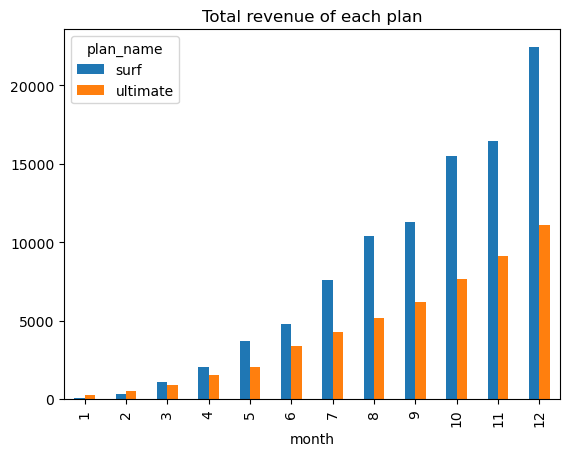

In [153]:
sum_revenue=final_table.pivot_table(index='month', columns= 'plan_name', values='revenue_total', aggfunc='sum')
display(sum_revenue)
sum_revenue.plot(kind='bar')
plt.title('Total revenue of each plan')
plt.show()

plan_name,surf,ultimate
month,,
1,20.000000,70.000000
2,34.396667,70.000000
3,45.941304,74.666667
4,40.710600,73.000000
5,47.628182,70.724138
6,49.276289,71.638298
7,62.674050,71.898305
8,63.931173,72.859155
9,58.219948,72.034884


<AxesSubplot:xlabel='month'>

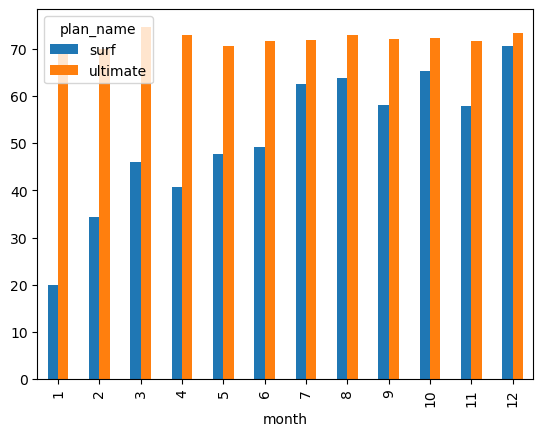

In [115]:
mean_revenue=final_table.pivot_table(index='month', columns= 'plan_name', values='revenue_total', aggfunc='mean')
display(mean_revenue)
mean_revenue.plot(kind='bar')
plt.title('Mean values of revenue of each plan')
plt.show()

In [116]:
ultimate_var_rev=ultimate.groupby('month')['revenue_total'].apply(lambda x: np.var(x))
surf_var_rev=surf.groupby('month')['revenue_total'].apply(lambda x: np.var(x))

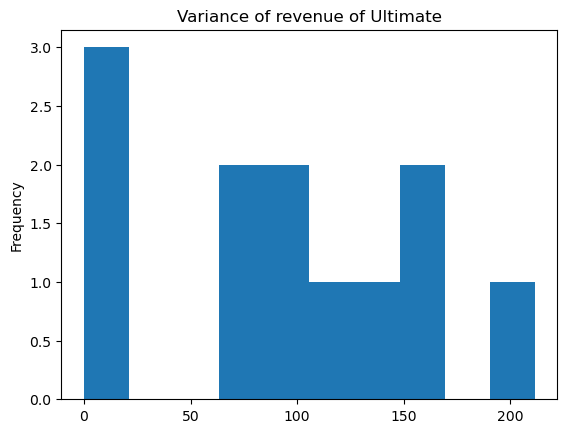

In [159]:
ultimate_var_rev.plot(kind='hist')
plt.title('Variance of revenue of Ultimate')
plt.show()

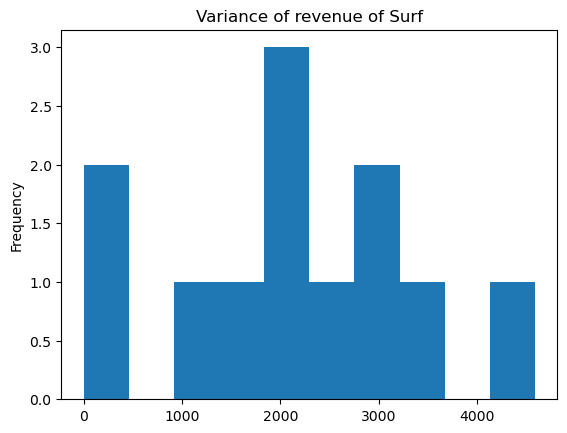

In [160]:
surf_var_rev.plot(kind='hist')
plt.title('Variance of revenue of Surf')
plt.show()

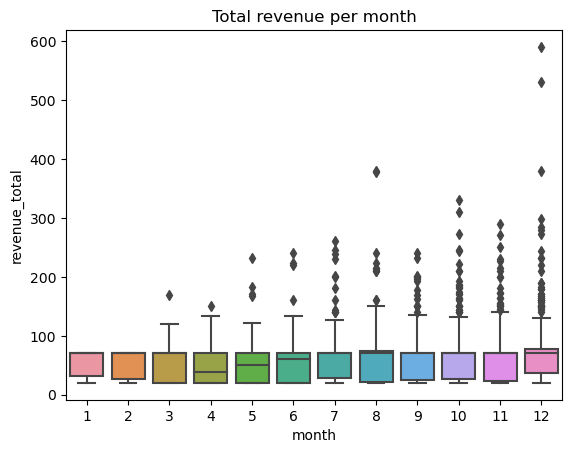

In [161]:
# Plot a boxplot to visualize the distribution of the monthly revenue
sns.boxplot(data=final_table, y="revenue_total", x="month")
plt.title('Total revenue per month')
plt.show()

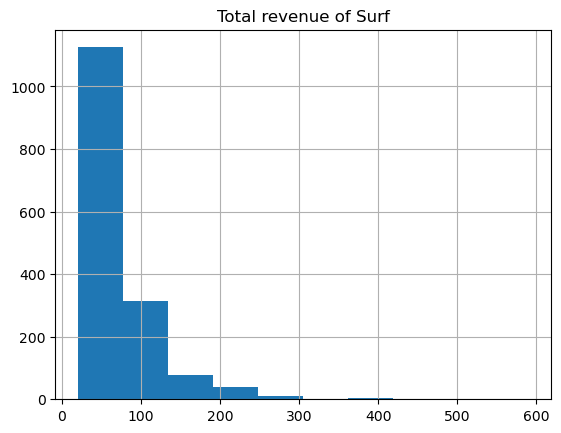

In [163]:
surf['revenue_total'].hist();
plt.title('Total revenue of Surf')
plt.show()

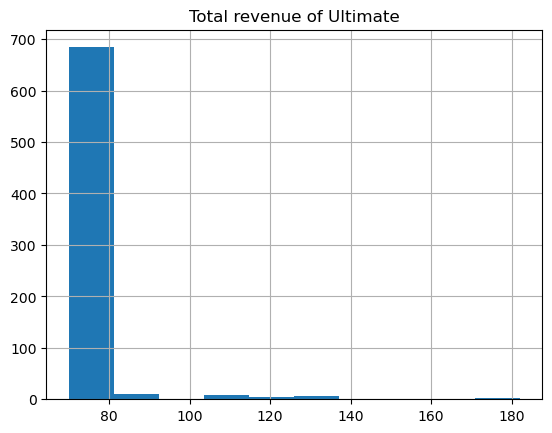

In [162]:
ultimate['revenue_total'].hist();
plt.title('Total revenue of Ultimate')
plt.show()

In [121]:
surf_st_dev_rev=np.sqrt(surf_var_rev)

In [122]:
ultimate_st_dev_rev=np.sqrt(ultimate_var_rev)

In [123]:
display(surf_st_dev_rev)

month
1      0.000000
2     19.511275
3     38.030032
4     34.277970
5     44.067988
6     44.366764
7     54.028353
8     59.710551
9     47.288945
10    56.444985
11    49.853474
12    67.749034
Name: revenue_total, dtype: float64

In [124]:
display(ultimate_st_dev_rev)

month
1      0.000000
2      0.000000
3     11.549411
4     10.708252
5      3.831778
6      8.568685
7     10.134176
8     12.354273
9      8.663540
10    12.961746
11     9.691388
12    14.541373
Name: revenue_total, dtype: float64

The average user of Ultimate plan doesn't spend money above the mandatory payment.This plan is more expensive but conteins much more minutes,messages and mb of the Internet, that is enough for clients. The Surf plan is much cheaper but users have to pay money for extra minutes,messages and mb of the Internet. In absolute terms the Surf plan brings more money because there are more clients who use this plan. The total payment for both plans become higher from the beginning of the year to the end of the year. But while we were studying the plot with information about distribution of revenue by months, we noticed that actually it was almost the same. But there are many extremely high values and they tend to increase by the end of the year. Our conclusionLet'ss сonfirms by the histograms and variance.

## Test statistical hypotheses

Our null hypothesis will be: the average revenue from users of the Ultimate and Surf calling plans doesn't differ.

Alternative hypothesis: Average revenue from users of Ultimate and Surf plans differs.

We have two independet samples: users of Ultimate and users of Surf so we need st.ttest_ind() to compare them. Let's take alpha = 0,05.

In [125]:
# Test the hypotheses
from scipy import stats as st
surf = final_table[final_table['plan_name']=='surf']
ultimate = final_table[final_table['plan_name']=='ultimate']
alpha=0.05
results= st.ttest_ind(ultimate['revenue_total'],surf['revenue_total'],equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 2.8239035478922904e-15
We reject the null hypothesis



According to our result's we have to reject the null hypothesis. And accept alternative hypothesis.

   Our null hypothesis will be: the average revenue from users in the NY-NJ area isn't different from that of the users from the other regions.
   
   Alternative hypothesis: the average revenue from users in the NY-NJ area differs from the average revenue of the users from the other regions.
    
   We have two independet samples: users in NY-NJ area iand users from the other regions. So we need st.ttest_ind() to compare them. Let's take alpha = 0,05. 
  

In [126]:
# Test the hypotheses
ny_nj = final_table[final_table['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']
other_area = final_table[final_table['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']
alpha=0.05
results= st.ttest_ind(ny_nj['revenue_total'],other_area['revenue_total'],equal_var=False)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.03404215637395888
We reject the null hypothesis


   According to our data, we can't reject the null hypothesis and should accept alternative hypothesis that there is positive relationship between the average revenue from users in the NY-NJ area and from  users from the other regions

### General conclusions

   To study telecom operator Megaline's prepaid plans (Surf and Ultimate), we took 5 separate data sets. The data wasn't in a perfect condition. We had to replace missing values, to change data types and column names, to round up some values, to count new parameters. Fortunately we had no duplicates. When our data was clean, we aggregate and merge it.
    
   We studied data about client's calls. Total calls duration is higher among Surf client's, but we remember that Surf users are twice as many as Ultimate clients. The duration is low in the beginning of the year and is growing by the end of the year. Variance is also slightly growing to the end of the year. The average values of both plan's calls are close. So we can sum up that calls activity of Surf's and Ultimate's clients are almost the same and the reason why we saw a bigger total duration of calls among Surf users is their bigger amount.
  
   The situation with the Internet looks similar to calls. Surf users consume more mb of the Internet but the average values of this parameter are close between Surf and Ultimate users. Clients of the mobile plans use the same amount of the Internet during the year.
    
   There is a bigger total number of messages were typed by Surf users, but we still keep in mind that there are more of them. The average values tell us that Ultimate users are more active in writing messages.

   The main goal of our analysis is to study revenue of each plan. We can say that users of Ultimate plan rather don't spend money above the mandatory payment.This plan costs more but contains much more minutes,messages and mb of Internet, that is enough for clients. Surf plan is much cheaper but users need extra minutes,messages and mb of te Internet and have to pay for them. The Surf plan brings more money because there are more clients who use this plan. The total revenue from both of the plans is almost the same. But there are many extremely high values and they tend to increase by the end of the year.

   During the analysis we formulated two null hypothesis and test them. The first one was the average revenue from users of the Ultimate and Surf calling plans doesn't differ. The second one was that the average revenue from users in the NY-NJ area isn't different from that of the users from the other regions. We used st.ttest_ind() to test them on two independet samples. In the result we had to reject both of these hypotheses and accept alternative hypotheses:there is positive relationship between the average revenue from users of the Ultimate and Surf calling plans and there is positive relationship between the average revenue from users in the NY-NJ area and from users from the other regions.